In [1]:
#optional installations: 
#!pip install yfinance --upgrade --no-cache-dir
#!pip3 install pandas_datareader

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time

#newest yahoo API 
import yfinance as yahoo_finance

#optional 
#yahoo_finance.pdr_override()

%matplotlib inline


connected to yahoo


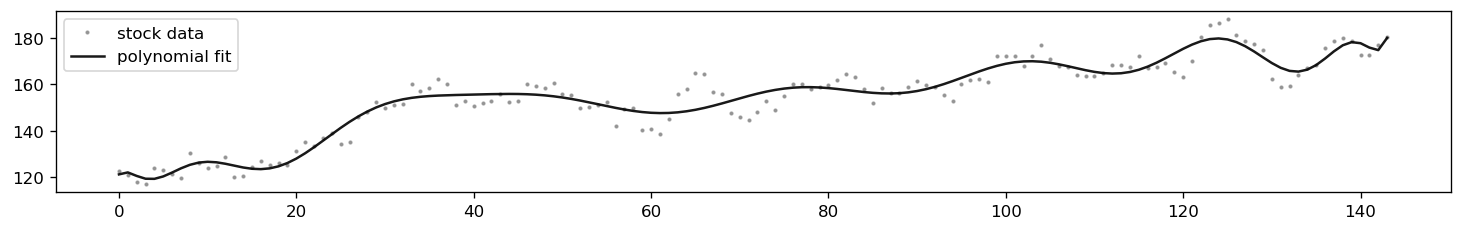

In [2]:
# ___variables___
ticker = 'PAMP.BA'
start_time = '2021-09-01'
end_time = '2022-04-01'
connected = False
while not connected:
    try:
        ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
        connected = True
        print('connected to yahoo')
    except Exception as e:
        print("type error: " + str(e))
        time.sleep( 5 )
        pass   
ticker_df = ticker_df.reset_index()

# discrete dataset
x_data = ticker_df.index.tolist()      # the index will be our x axis, not date
y_data = ticker_df['Low']

# x values for the polynomial fit, 200 points
x = np.linspace(0, max(ticker_df.index.tolist()), max(ticker_df.index.tolist()) + 1)

# polynomial fit of degree xx
pol = np.polyfit(x_data, y_data, 17)
y_pol = np.polyval(pol, x)

#           ___ plotting ___
plt.figure(figsize=(15, 2), dpi= 120, facecolor='w', edgecolor='k')

# plot stock data
plt.plot(x_data, y_data, 'o', markersize=1.5, color='grey', alpha=0.7)

# plot polynomial fit
plt.plot(x, y_pol, '-', markersize=1.0, color='black', alpha=0.9)
plt.legend(['stock data', 'polynomial fit'])
plt.show()

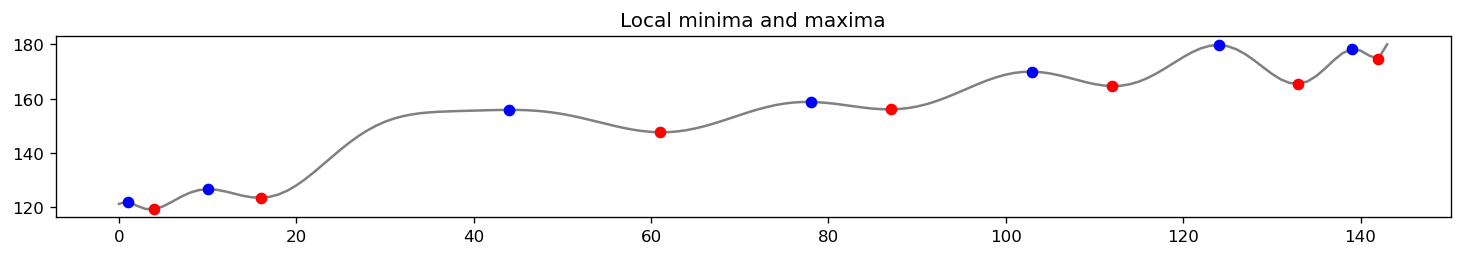

l_min:  [  4  16  61  87 112 133 142]


In [3]:
data = y_pol

#           ___ detection of local minimums and maximums ___

min_max = np.diff(np.sign(np.diff(data))).nonzero()[0] + 1          # local min & max
l_min = (np.diff(np.sign(np.diff(data))) > 0).nonzero()[0] + 1      # local min
l_max = (np.diff(np.sign(np.diff(data))) < 0).nonzero()[0] + 1      # local max
# +1 due to the fact that diff reduces the original index number

# plot
plt.figure(figsize=(15, 2), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(x, data, color='grey')
plt.plot(x[l_min], data[l_min], "o", label="min", color='r')        # minima
plt.plot(x[l_max], data[l_max], "o", label="max", color='b')        # maxima
plt.title('Local minima and maxima')
plt.show()

print('l_min: ', l_min)

In [4]:
#print('corresponding LOW values for suspected indeces: ')
#print(ticker_df.Low.iloc[l_min])

#extend the suspected x range:
delta = 5                                       # how many ticks to the left and to the right from local minimum on x axis

dict_i = dict()
dict_x = dict()

df_len = len(ticker_df.index)                    # number of rows in dataset

for element in l_min:                            # x coordinates of suspected minimums
    l_bound = element - delta                    # lower bound (left)
    u_bound = element + delta                    # upper bound (right)
    x_range = range(l_bound, u_bound + 1)        # range of x positions where we SUSPECT to find a low
    dict_x[element] = x_range                    # just helpful dictionary that holds suspected x ranges for further visualization strips
    
    #print('x_range: ', x_range)
    
    y_loc_list = list()
    for x_element in x_range:
        #print('-----------------')
        if x_element > 0 and x_element < df_len:                # need to stay within the dataframe
            #y_loc_list.append(ticker_df.Low.iloc[x_element])   # list of suspected y values that can be a minimum
            y_loc_list.append(ticker_df.Low.iloc[x_element])
            #print(y_loc_list)
            #print('ticker_df.Low.iloc[x_element]', ticker_df.Low.iloc[x_element])
    dict_i[element] = y_loc_list                 # key in element is suspected x position of minimum
                                                 # to each suspected minimums we append the price values around that x position
                                                 # so 40: [53.70000076293945, 53.93000030517578, 52.84000015258789, 53.290000915527344]
                                                 # x position: [ 40$, 39$, 41$, 45$]
#print('DICTIONARY for l_min: ', dict_i)

In [5]:
y_delta = 0.12                               # percentage distance between average lows
threshold = min(ticker_df['Low']) * 1.3      # setting threshold higher than the global low

y_dict = dict()
mini = list()
suspected_bottoms = list()
                                              #   BUG somewhere here
for key in dict_i.keys():                     # for suspected minimum x position  
    mn = sum(dict_i[key])/len(dict_i[key])    # this is averaging out the price around that suspected minimum
                                              # if the range of days is too high the average will not make much sense
        
    price_min = min(dict_i[key])    
    mini.append(price_min)                    # lowest value for price around suspected 
    
    l_y = mn * (1.0 - y_delta)                #these values are trying to get an U shape, but it is kinda useless 
    u_y = mn * (1.0 + y_delta)
    y_dict[key] = [l_y, u_y, mn, price_min]
    
#print('y_dict: ') 
#print(y_dict) 

#print('SCREENING FOR DOUBLE BOTTOM:')    
    
for key_i in y_dict.keys():    
    for key_j in y_dict.keys():    
        if (key_i != key_j) and (y_dict[key_i][3] < threshold):
            suspected_bottoms.append(key_i)    

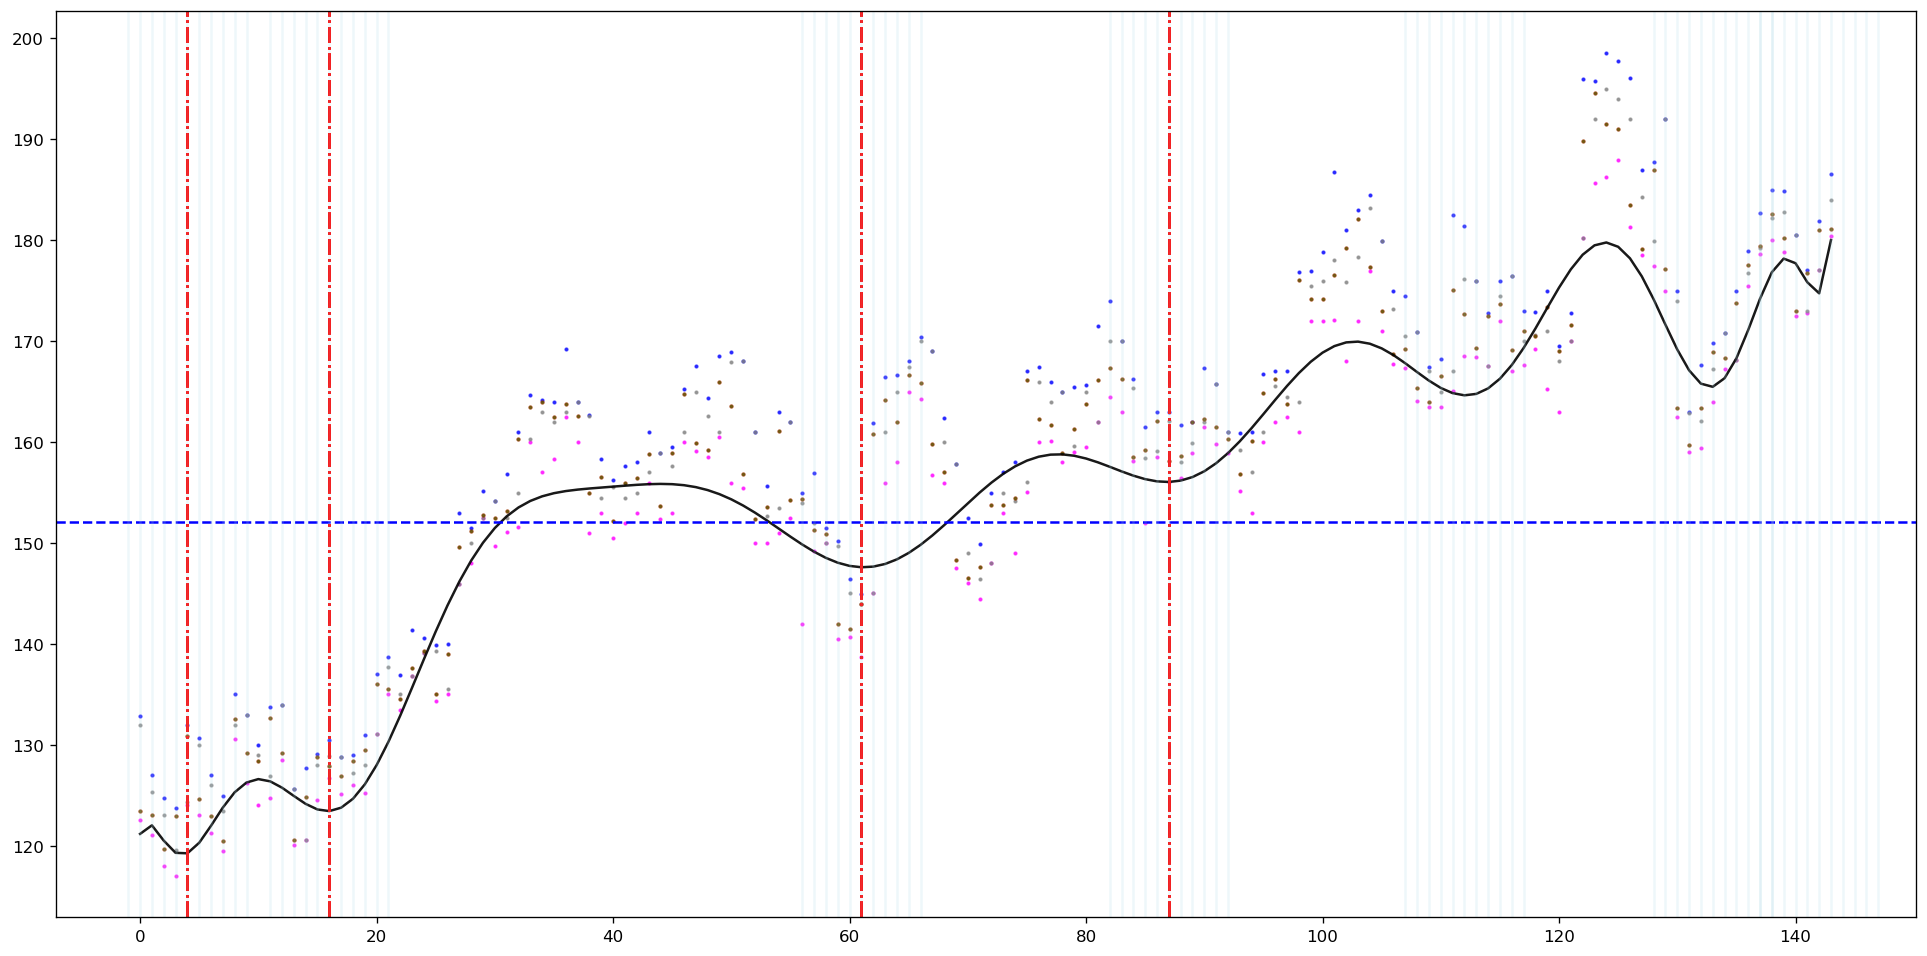

In [6]:
# ___ plotting ___
plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
# plot stock data
plt.plot(x_data, y_data, 'o', markersize=1.5, color='magenta', alpha=0.7)

# we can plot also all the other prices to get a price range for given day just for information
plt.plot(x_data, ticker_df['High'],      'o', markersize=1.5, color='blue',  alpha=0.7)
plt.plot(x_data, ticker_df['Open'],      'o', markersize=1.5, color='grey',  alpha=0.7)
plt.plot(x_data, ticker_df['Close'],     'o', markersize=1.5, color='red', alpha=0.7)    # Adj Close should be more accurate indication (accounts for dividends and stock splits)
plt.plot(x_data, ticker_df['Adj Close'], 'o', markersize=1.5, color='green', alpha=0.4)


# plot polynomial fit
plt.plot(x, y_pol, '-', markersize=1.0, color='black', alpha=0.9)

for position in suspected_bottoms:
    plt.axvline(x=position, linestyle='-.', color='r')
    
plt.axhline(threshold, linestyle='--', color='b')    


for key in dict_x.keys():
    #print('dict key value: ', dict_i[key])
    for value in dict_x[key]:
        plt.axvline(x=value, linestyle='-', color = 'lightblue', alpha=0.2)


plt.show()

# print('dict_x: ', dict_x)   # this dictionary is holding the values of the suspected low price
# print('y_dict:', y_dict)